In order to use a classifier for read_state you need a training set of image squares for your game.  See 2023-11-17 - Make a training image set of squares.ipynb to do that.

In this example, my training set is in the folder "images/training squares".

We'll start by debugging, and making sure it works, before making a complete read_state function

In [48]:
%matplotlib inline
from pylab import *
from classy import *
from Game import Board

Version:  0.2.42


In [35]:
images=image.load_images('images/training squares/')
images=remap_targets(images,new_target_names=['blank','player1','player2'])
summary(images)

[player1]: 58 files found
[blank]: 46 files found
[player2]: 56 files found
Images
160 images of shape (50, 50, 3)
Target values given.
Target names: 'blank', 'player1', 'player2'
[blank]: 46 files
[player1]: 58 files
[player2]: 56 files


In [36]:
data=image.images_to_vectors(images)

160 vectors of length 7500
Feature names: 'p0', 'p1', 'p2', 'p3', 'p4'  , ... ,  'p7495', 'p7496', 'p7497', 'p7498', 'p7499'  (7500 features)
Target values given.
Target names: 'blank', 'player1', 'player2'
Mean:  [140.2625  148.4     142.60625 ... 184.03125 187.775   178.65   ]
Median:  [153.5 165.5 156.5 ... 184.5 188.  180. ]
Stddev:  [47.13829222 50.04475497 50.55419083 ...  7.69043389 14.55032216
 13.42209   ]


This should really be 100% -- if it can't identify the data that it knows about, it will make errors on any test

In [37]:
C=NaiveBayes()
C.fit(data.vectors,data.targets)
print("On the full data set:",C.percent_correct(data.vectors,data.targets))

On the full data set: 100.0


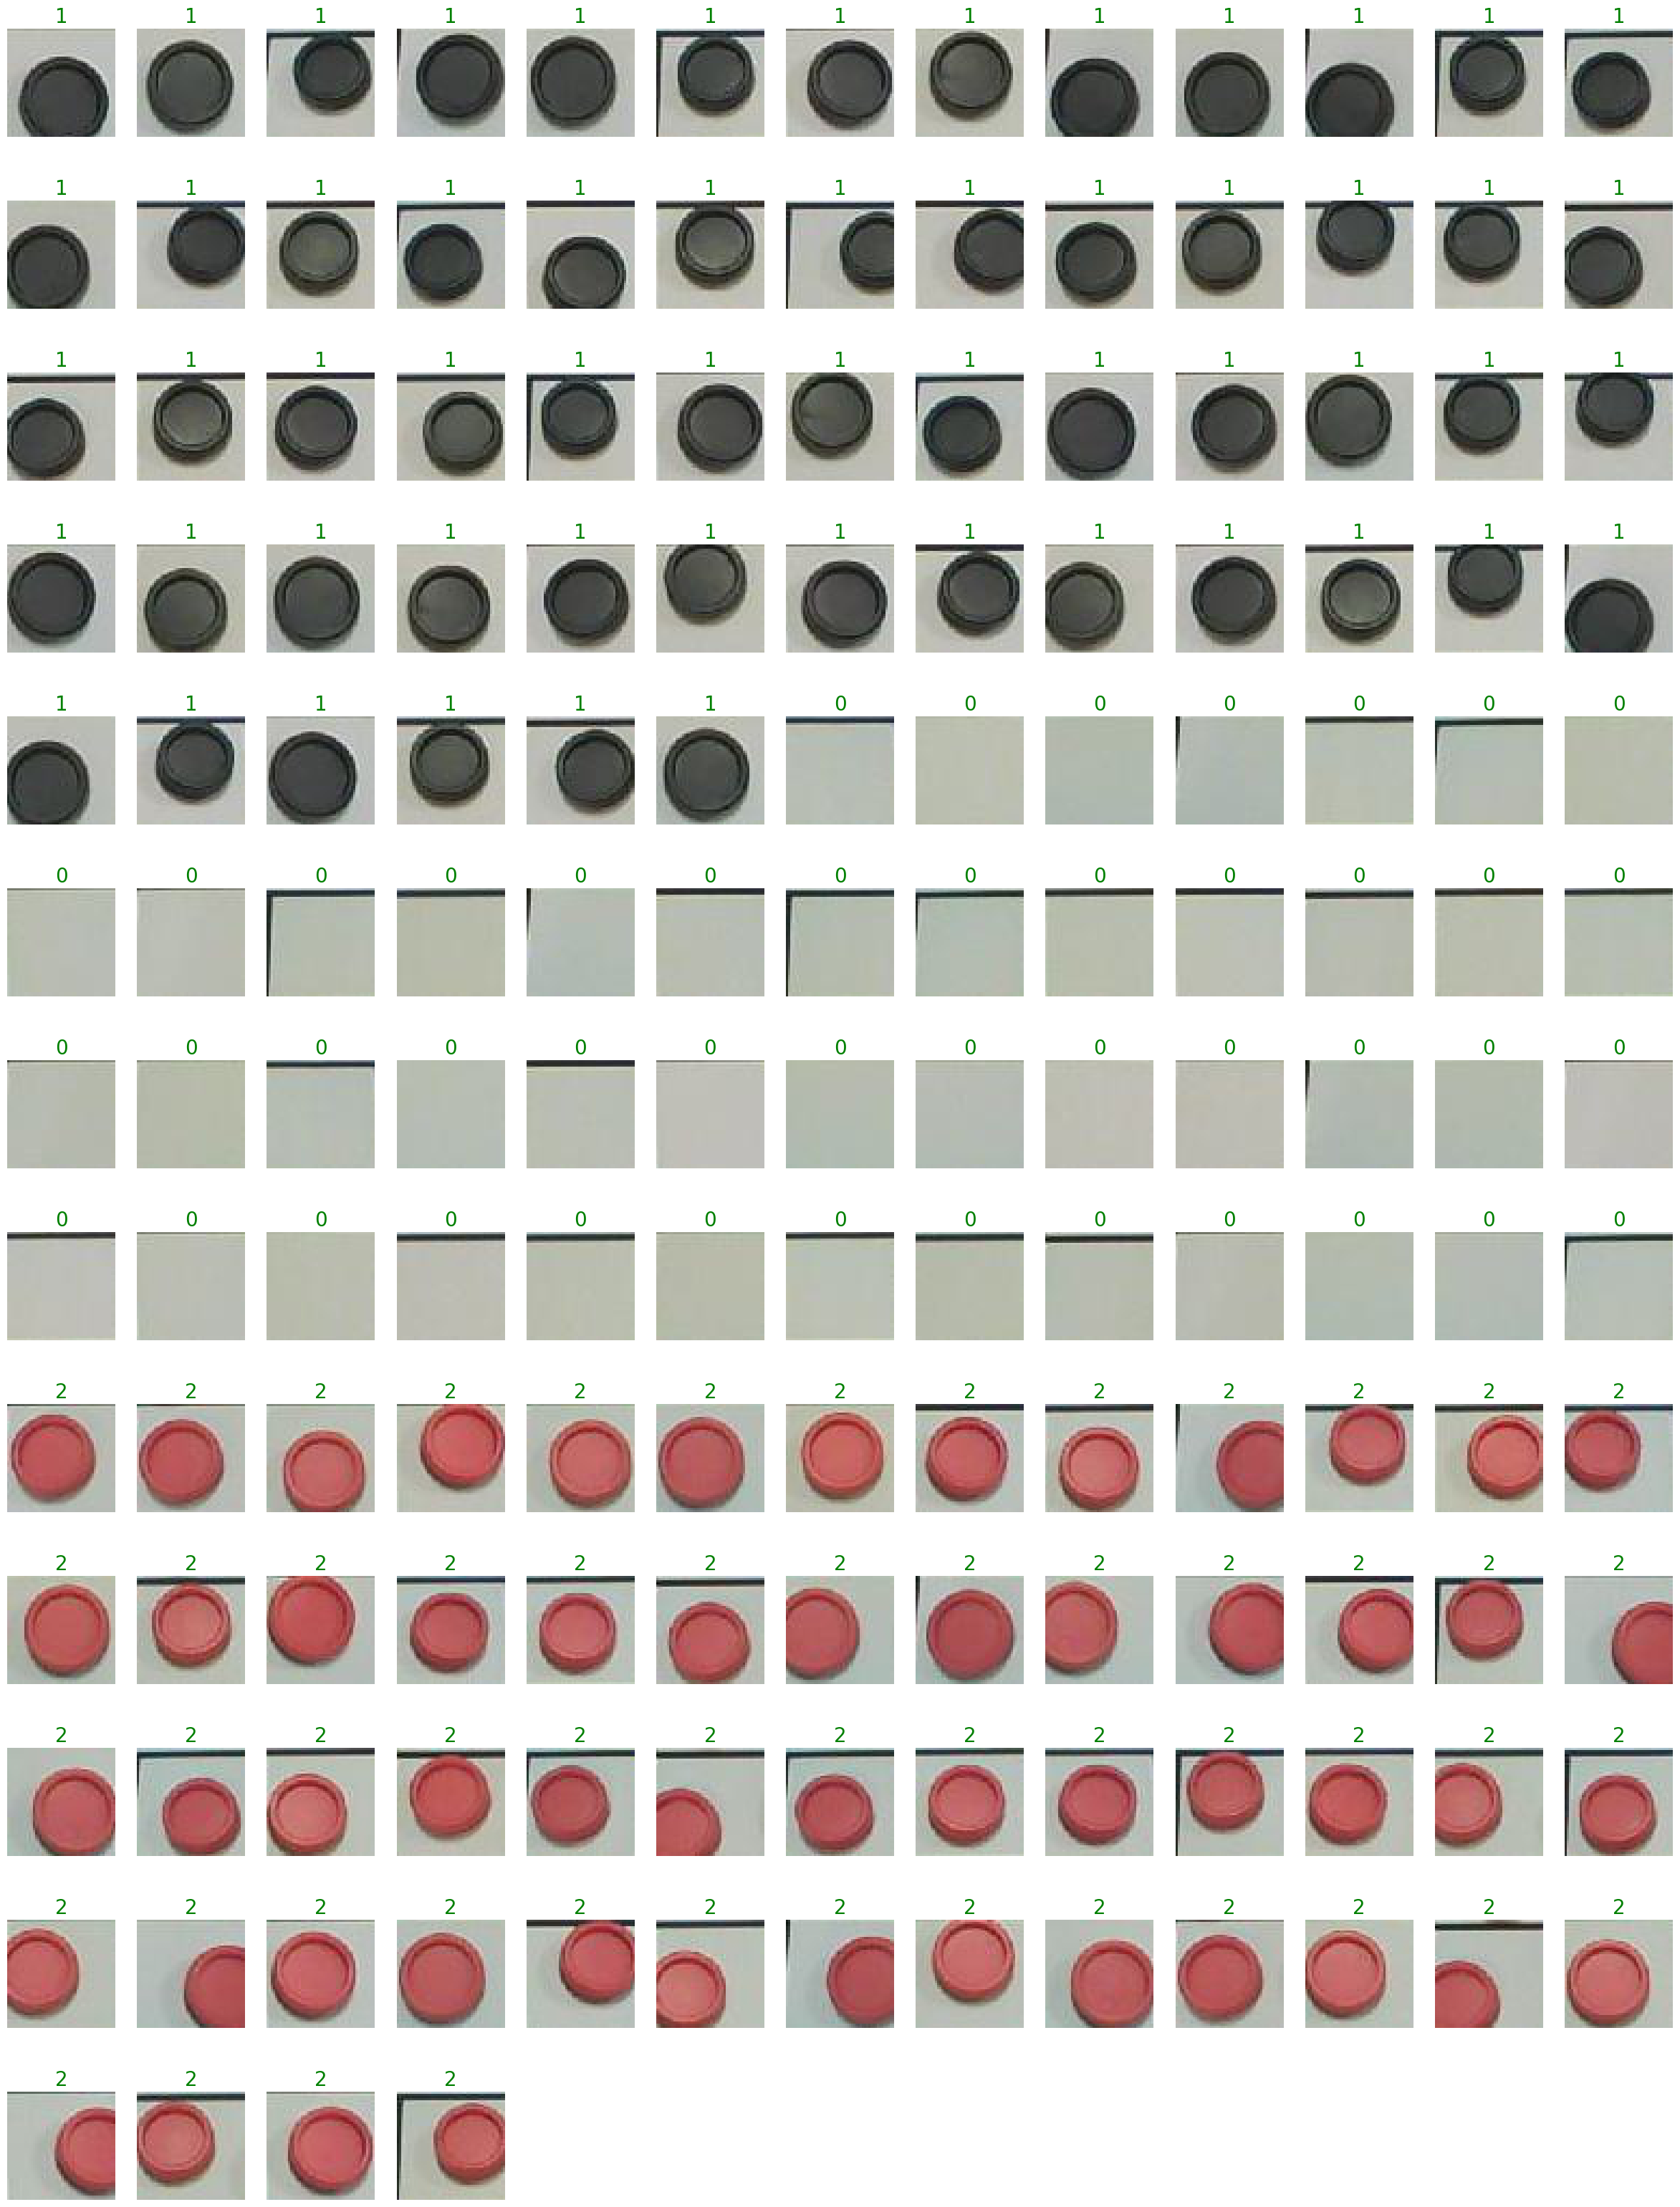

In [40]:
predictions=C.predict(data.vectors)
figure(figsize=(30,40))
names=[data.target_names[p] for p in predictions]

L=len(data.vectors)
num_rows=int(ceil(sqrt(L)))
num_cols=L//num_rows+1
for i in range(L): #range(len(data.vectors)):
    subplot(num_rows,num_cols,i+1)
    vector=data.vectors[i,:]
    im=vector.reshape(images.data[0].shape)
    im=im/255
    imshow(im)
    axis('off')
    
    
    if predictions[i]==data.targets[i]:
        title(predictions[i],color='green')
    else:
        title(predictions[i],color='red')
        

Funny side note:  My classifier wasn't 100%, but I went on to this stage anyway.  When I plotted the mistakes I got:
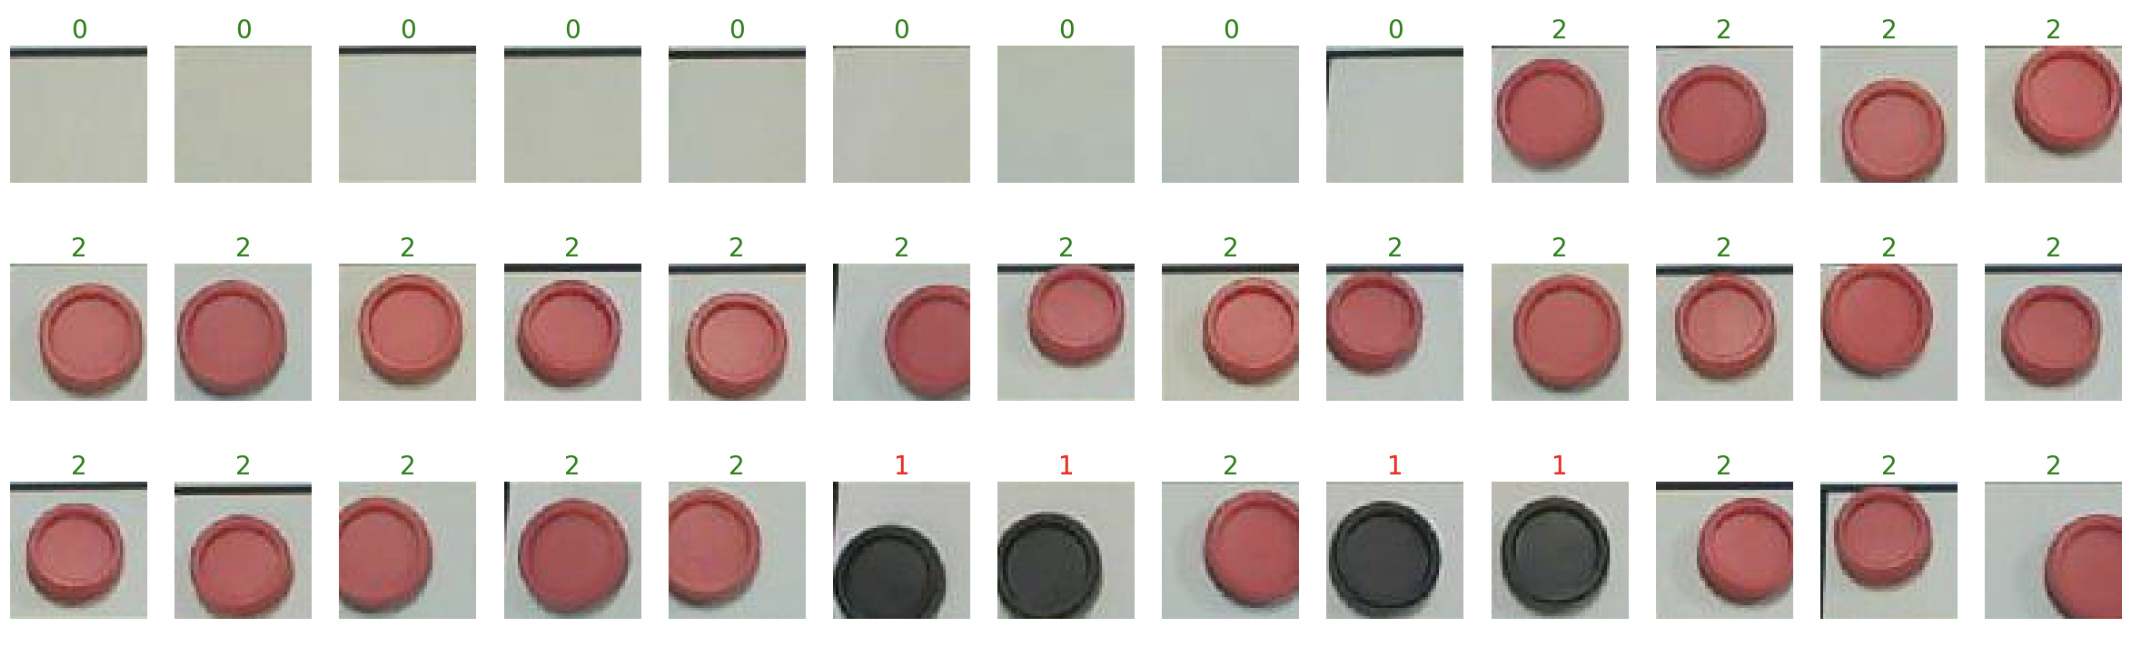
which means that I put the wrong images into the folders -- my classifier was better than me in identifying the images.

## Now let's convert an image to a game state

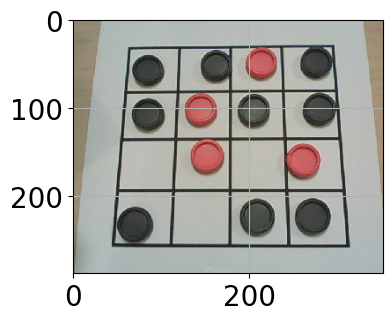

In [43]:
fname='images/board images/test9.jpg'
im=imread(fname)
figure(figsize=(4,4))
imshow(im)

slice into squares

In [49]:
square_size=50 # choose a size that works for you
import json
with open('locations.json') as json_file:
    locations = json.load(json_file)

count=0
im=imread(fname)

values=[]
for r,c in locations:
    sr=r-square_size//2
    er=sr+square_size
    sc=c-square_size//2
    ec=sc+square_size   
    subimage=im[sr:er,sc:ec,:]

    # convert the square image to a data vector for the classifier
    vector=subimage.ravel()
    prediction=C.predict(atleast_2d(vector))[0]

    values.append(prediction)

    count+=1

In [50]:
state=Board(4,4)
state.board=values
state

 1  1  2  1 
 1  2  1  1 
 0  2  0  2 
 1  0  1  1 

## Now put it all together into read_state
    

In [51]:
def read_state_from_file(filename):
    text=open(filename).read()
    text=text.strip()
    lines=[line.strip() for line in text.split('\n')]  # get rid of \n
    
    row=lines[0].split()
    R,C=len(lines),len(row)
    print(f"{R}x{C} board")
    state=Board(R,C)
    state.board=[int(val) for val in text.split()]  
    print(state)
    return state

In [54]:
def take_picture(fname):  # in jupyter have this, but don't put this on your robot!
    pass

In [59]:
def read_state():
    from pylab import imread,imsave
    import os

    # train the classifier
    images=image.load_images('images/training squares/',delete_alpha=True)  #<=========
    shape=images.data[0].shape[:2]
    data=image.images_to_vectors(images,verbose=True)  # train on all of them

    #classifier=kNearestNeighbor()
    classifier=NaiveBayes()
    classifier.fit(data.vectors,data.targets)


    # get the picture
    fname='current_board.jpg'              # for the robot
    fname='images/board images/test9.jpg'  # for debugging in jupyter
    take_picture(fname)
    im=imread(fname)

    # slice the picture into squares of the right size
    square_size=50 # choose a size that works for you
    import json
    with open('locations.json') as json_file:
        locations = json.load(json_file)

    count=0
    # for debugging
    if not os.path.exists('images/predicted'):
        os.mkdir('images/predicted')
    
    values=[]
    for r,c in locations:
        sr=r-square_size//2
        er=sr+square_size
        sc=c-square_size//2
        ec=sc+square_size   
        subimage=im[sr:er,sc:ec,:]
    
        # convert the square image to a data vector for the classifier
        vector=subimage.ravel()
        prediction=C.predict(atleast_2d(vector))[0]
    
        values.append(prediction)

        # for debugging
        imsave('images/predicted/square %d predicted as %s.jpg' % (count,data.target_names[prediction]),subimage)
    
        count+=1

    
    # reconstruct the state from the predictions
    state=Board(4,4)                                      #<========= change the size
    state.board=values

    print("Current state is:")
    print(state)

    x=input("""
    Hit return if this is correct, otherwise type a character 
    and the state will be read from current_board.txt.""")

    if x:
        print("Reading from file...")
        state=read_state_from_file('board.txt')

    print("Using")
    print(state)

    
    return state


In [61]:
state=read_state()

[player1]: 58 files found
[blank]: 46 files found
[player2]: 56 files found
160 vectors of length 7500
Feature names: 'p0', 'p1', 'p2', 'p3', 'p4'  , ... ,  'p7495', 'p7496', 'p7497', 'p7498', 'p7499'  (7500 features)
Target values given.
Target names: 'player1', 'blank', 'player2'
Mean:  [140.2625  148.4     142.60625 ... 184.03125 187.775   178.65   ]
Median:  [153.5 165.5 156.5 ... 184.5 188.  180. ]
Stddev:  [47.13829222 50.04475497 50.55419083 ...  7.69043389 14.55032216
 13.42209   ]
Current state is:
 1  1  2  1 
 1  2  1  1 
 0  2  0  2 
 1  0  1  1 




    Hit return if this is correct, otherwise type a character 
    and the state will be read from current_board.txt. x


Reading from file...
4x4 board
 0  0  0  0 
 1  1  1  1 
 2  2  2  2 
 0  0  0  0 

Using
 0  0  0  0 
 1  1  1  1 
 2  2  2  2 
 0  0  0  0 

